In [1]:
import pandas as pd
import numpy as np
import re
import json
import math
import scipy.stats as stats
import statsmodels.api as sm
import statsmodels.formula.api as smf
import seaborn as sns
import matplotlib.pyplot as plt

In [8]:
with open('/code/human-learning-strategies/responses/meditron-70b_medqa.json') as f:
    data = json.load(f)
df = pd.DataFrame(data['questions'])

sum(df['correct_answer'] == df['response'])/len(df)
    

0.4046964040086461

In [3]:
def load_responses(filepath):
    with open(filepath) as f:
        data = json.load(f)

    df = pd.DataFrame(data['questions'])

    return df

def category_filter(df, category):
    subset = df[df['Category'] == category].copy()
    return subset


def correct_filter(df, incorrect=False):
    subset = df[(df['correct_answer'] == df['response']) != incorrect].copy()
    return subset

In [4]:
def correct(df):
    df['correct'] = df['correct_answer'] == df['response']
    return df['correct'].sum()

def accuracy(df):
    df['correct'] = df['correct_answer'] == df['response']
    return df['correct'].sum() / len(df['correct'])

def expected_correct(df):
    df['expected_correct'] = df.apply(lambda x: math.exp(x['clls'][['A','B','C','D','E'].index(x['correct_answer'])]),axis=1)
    return df['expected_correct'].sum()

def expected_accuracy(df):
    df['expected_correct'] = df.apply(lambda x: math.exp(x['clls'][['A','B','C','D','E'].index(x['correct_answer'])]),axis=1)
    return df['expected_correct'].sum()/len(df)


def expected_correct_series(df):
    df['expected_correct'] = df.apply(lambda x: math.exp(x['clls'][['A','B','C','D','E'].index(x['correct_answer'])]),axis=1)
    return df['expected_correct'].values

def expected_accuracy_series(df):
    df['expected_correct'] = df.apply(lambda x: math.exp(x['clls'][['A','B','C','D','E'].index(x['correct_answer'])]),axis=1)
    return df['expected_correct'].values

In [5]:
def weight_dist(df):
    sorted_clls = pd.DataFrame(df['clls'].apply(lambda x: np.exp(np.array(sorted(x,reverse=True)))).tolist())
    return (sorted_clls.sum() / len(df)).values


In [6]:
dataset = 'medqa'

models = {#'GPT 4 Turbo': 'gpt-4-1106-preview',
          #'GPT 3.5': 'gpt-3.5-turbo-1106',
          #'PaLM 2': 'text-bison@002',
          'Mistral 8x7B': 'Mixtral-8x7B-v0.1',
          'Meditron 70B': 'meditron-70b', 
          'Llama 2 70B':  'Llama-2-70b-chat-hf',
          }

models_df = pd.DataFrame.from_dict(models, columns = ['hf_name'], orient='index')

models_df['filepath'] = '../responses/' + models_df['hf_name'] + '_'+dataset+'.json'

models_df['n_correct'] = models_df.apply(lambda x: correct(load_responses(x['filepath'])),axis=1) 
models_df['raw_accuracy'] = models_df.apply(lambda x: accuracy(load_responses(x['filepath'])),axis=1) 
models_df['expected_correct'] = models_df.apply(lambda x: expected_correct(load_responses(x['filepath'])),axis=1)
models_df['expected_accuracy'] = models_df.apply(lambda x: expected_accuracy(load_responses(x['filepath'])),axis=1)
models_df['expected_correct_series'] = models_df.apply(lambda x: expected_correct_series(load_responses(x['filepath'])),axis=1)
models_df['expected_accuracy_series'] = models_df.apply(lambda x: expected_accuracy_series(load_responses(x['filepath'])),axis=1)

<Axes: >

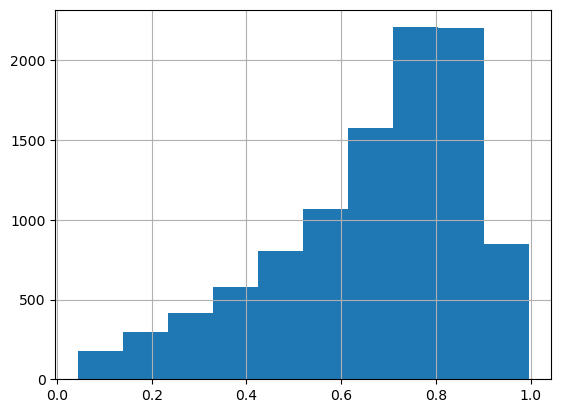

In [7]:
difficulty = 1 - models_df['expected_accuracy_series'].mean()
pd.Series(difficulty).hist()
